# Generative adversarial network (GAN) for [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit dataset

During the workshop, you were shown how to implement a previously trained GAN. The task of building and training your own neural network that generates MRI data is an arduous one, often worthy of a PhD.\
\
Today, you will be given a few tasks that will allow you to examine a more basic GAN implementation found [here](https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb), that uses PyTorch and the MNIST handwritten digit dataset (you can find another, almost identical, script to do this [here](https://github.com/jsuarez5341/GAN-MNIST-Pytorch/blob/master/main.py)).\
\
This model is a lot simpler than what you would need to generate high-resolution and 3D MR images, but it will allow you to gain a better intuition for the architecture of GANs. Have fun filling in the blanks! :)

# Part 1: fill in the missing code

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
BATCH_SIZE = 100

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"You have {len(train_loader)} training instances and {len(test_loader)} testing instances.")


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

You have 600 training instances and 100 testing instances.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Take a quick look at your data

In [3]:
it=iter(train_loader)

In [4]:
dataiter = iter(train_loader)
for i in range(3):
    images, labels = dataiter.next()
    print(images.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


**Questions:** \
(a) What information does each of the tensors above give you?\
(b) Are these images in grayscale or in color? \
(c) How many channels are there in these images? \
**Answers:** \
(a) BATCH_SIZE, number of channels, image width, image height\
(b) Grayscale! If they were in color, their dimensions would be ```torch.Size([100, 3, 28, 28])```\
(c) Just one! (An RGB image would have 3 channels)

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [6]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [7]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [8]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [10]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(BATCH_SIZE, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(BATCH_SIZE, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(BATCH_SIZE, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [11]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(BATCH_SIZE, z_dim).to(device))
    y = Variable(torch.ones(BATCH_SIZE, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [12]:
N_EPOCH = 12
for epoch in range(1, N_EPOCH+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), N_EPOCH, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/12]: loss_d: 0.923, loss_g: 2.835
[2/12]: loss_d: 1.046, loss_g: 1.594
[3/12]: loss_d: 1.101, loss_g: 1.732
[4/12]: loss_d: 0.921, loss_g: 1.730
[5/12]: loss_d: 0.506, loss_g: 2.705
[6/12]: loss_d: 0.551, loss_g: 2.487
[7/12]: loss_d: 0.625, loss_g: 2.492
[8/12]: loss_d: 0.639, loss_g: 2.281
[9/12]: loss_d: 0.642, loss_g: 2.195
[10/12]: loss_d: 0.697, loss_g: 2.175
[11/12]: loss_d: 0.725, loss_g: 2.107
[12/12]: loss_d: 0.758, loss_g: 2.020


In [14]:
os.mkdir("generated_digits_part_1")
with torch.no_grad():
    test_z = Variable(torch.randn(BATCH_SIZE, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), f'generated_digits_part_1/sample_{BATCH_SIZE}batchSize{BATCH_SIZE}_{N_EPOCH}epochs.png')

FileExistsError: ignored

generated_digits_part_1/sample_100batchSize100_12epochs.png :


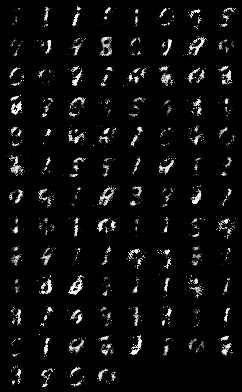

In [16]:
import glob

from IPython.display import Image

for im in glob.glob('generated_digits_part_1/*.png'):
    print(f"{im} :")
    display(Image(im))

# Part 2: testing different batch sizes and numbers of epochs
Convert the code above into two nested loops that iterate through a list of batch sizes and epochs. Make sure to save your generated images with a meaningful naming convention (see above example). \
**Tip:** We recommend nesting your N_EPOCH loop within the code where it was defined above, not to have to reload the data with every iteration. You will however have to reload the data for each change in batch size.

In [17]:
# directory where you will store your outputs:
os.mkdir("generated_digits_part_2")

In [18]:
for BATCH_SIZE in [32,64,100]:

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # MNIST Dataset
    train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"You have {len(train_loader)} training instances and {len(test_loader)} testing instances.")

    class Generator(nn.Module):
        def __init__(self, g_input_dim, g_output_dim):
            super(Generator, self).__init__()       
            self.fc1 = nn.Linear(g_input_dim, 256)
            self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
            self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
            self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        
        # forward method
        def forward(self, x): 
            x = F.leaky_relu(self.fc1(x), 0.2)
            x = F.leaky_relu(self.fc2(x), 0.2)
            x = F.leaky_relu(self.fc3(x), 0.2)
            return torch.tanh(self.fc4(x))
        
    class Discriminator(nn.Module):
        def __init__(self, d_input_dim):
            super(Discriminator, self).__init__()
            self.fc1 = nn.Linear(d_input_dim, 1024)
            self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
            self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
            self.fc4 = nn.Linear(self.fc3.out_features, 1)
        
        # forward method
        def forward(self, x):
            x = F.leaky_relu(self.fc1(x), 0.2)
            x = F.dropout(x, 0.3)
            x = F.leaky_relu(self.fc2(x), 0.2)
            x = F.dropout(x, 0.3)
            x = F.leaky_relu(self.fc3(x), 0.2)
            x = F.dropout(x, 0.3)
            return torch.sigmoid(self.fc4(x))

    # build network
    z_dim = 100
    mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

    G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
    D = Discriminator(mnist_dim).to(device)

    # loss
    criterion = nn.BCELoss() 

    # optimizer
    lr = 0.0002 
    G_optimizer = optim.Adam(G.parameters(), lr = lr)
    D_optimizer = optim.Adam(D.parameters(), lr = lr)

    def D_train(x):
        #=======================Train the discriminator=======================#
        D.zero_grad()

        # train discriminator on real
        x_real, y_real = x.view(-1, mnist_dim), torch.ones(BATCH_SIZE, 1)
        x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

        D_output = D(x_real)
        D_real_loss = criterion(D_output, y_real)
        D_real_score = D_output

        # train discriminator on facke
        z = Variable(torch.randn(BATCH_SIZE, z_dim).to(device))
        x_fake, y_fake = G(z), Variable(torch.zeros(BATCH_SIZE, 1).to(device))

        D_output = D(x_fake)
        D_fake_loss = criterion(D_output, y_fake)
        D_fake_score = D_output

        # gradient backprop & optimize ONLY D's parameters
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
            
        return  D_loss.data.item()

    def G_train(x):
        #=======================Train the generator=======================#
        G.zero_grad()

        z = Variable(torch.randn(BATCH_SIZE, z_dim).to(device))
        y = Variable(torch.ones(BATCH_SIZE, 1).to(device))

        G_output = G(z)
        D_output = D(G_output)
        G_loss = criterion(D_output, y)

        # gradient backprop & optimize ONLY G's parameters
        G_loss.backward()
        G_optimizer.step()
            
        return G_loss.data.item()

    for N_EPOCH in [10,50,100,200]:
        for epoch in range(1, N_EPOCH+1):           
            D_losses, G_losses = [], []
            for batch_idx, (x, _) in enumerate(train_loader):
                D_losses.append(D_train(x))
                G_losses.append(G_train(x))

            print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                    (epoch), N_EPOCH, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

        with torch.no_grad():
            test_z = Variable(torch.randn(BATCH_SIZE, z_dim).to(device))
            generated = G(test_z)

            save_image(generated.view(generated.size(0), 1, 28, 28), f'generated_digits_part_2/sample_{BATCH_SIZE}batchSize{BATCH_SIZE}_{N_EPOCH}epochs.png')

KeyboardInterrupt: ignored

generated_digits_part_2/sample_32batchSize32_10epochs.png :


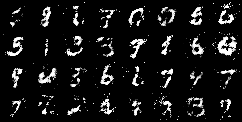

generated_digits_part_2/sample_32batchSize32_50epochs.png :


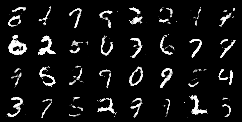

In [19]:
# take a look at all of these images!
for im in glob.glob('generated_digits_part_2/*.png'):
    print(f"{im} :")
    display(Image(im))